In [2]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import gseapy as gp
from bulkformer_2 import BulkFormer, model_params

device = "cuda" if torch.cuda.is_available() else "cpu"
device


/home/walt/miniconda3/envs/esm2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'cuda'

In [6]:
ckpt_path = "bulkformer_checkpoints/epoch_4.pt"   # or whichever epoch you want
state_dict = torch.load(ckpt_path, map_location="cpu")

import json

with open("bulkformer_checkpoints/config.json", "r") as f:
    cfg = json.load(f)

cfg

esm2_data = torch.load("./data/embeddings/esm2_t6_8M_UR50D_gene_embeddings.pt")
gene_emb = esm2_data["embeddings"].float()

edge_index = torch.load("./graph/edge_index_top20.pt").long()

In [8]:
model = BulkFormer(
    dim=cfg["dim"],
    graph=edge_index,                # You need to load this (see below)
    gene_emb=gene_emb,             # And this
    gene_length=cfg["num_genes"],
    bin_head=cfg["bin_head"],
    full_head=cfg["full_head"],
    bins=cfg["bins"],
    gb_repeat=cfg["gb_repeat"],
    p_repeat=cfg["p_repeat"],
)



In [9]:
model.load_state_dict(state_dict)
model = model.to("cuda")



In [10]:

with torch.no_grad():
    # gene identity embedding only
    gene_embed = model.gene_emb_proj(model.gene_emb)  # shape (19357, 320)

gene_embed = gene_embed.cpu().numpy()
gene_embed.shape



(19357, 320)

In [11]:
tsne = TSNE(
    n_components=2,
    learning_rate="auto",
    init="random",
    perplexity=30,
    random_state=42
)

tsne_emb = tsne.fit_transform(gene_embed)
tsne_emb.shape


(19357, 2)

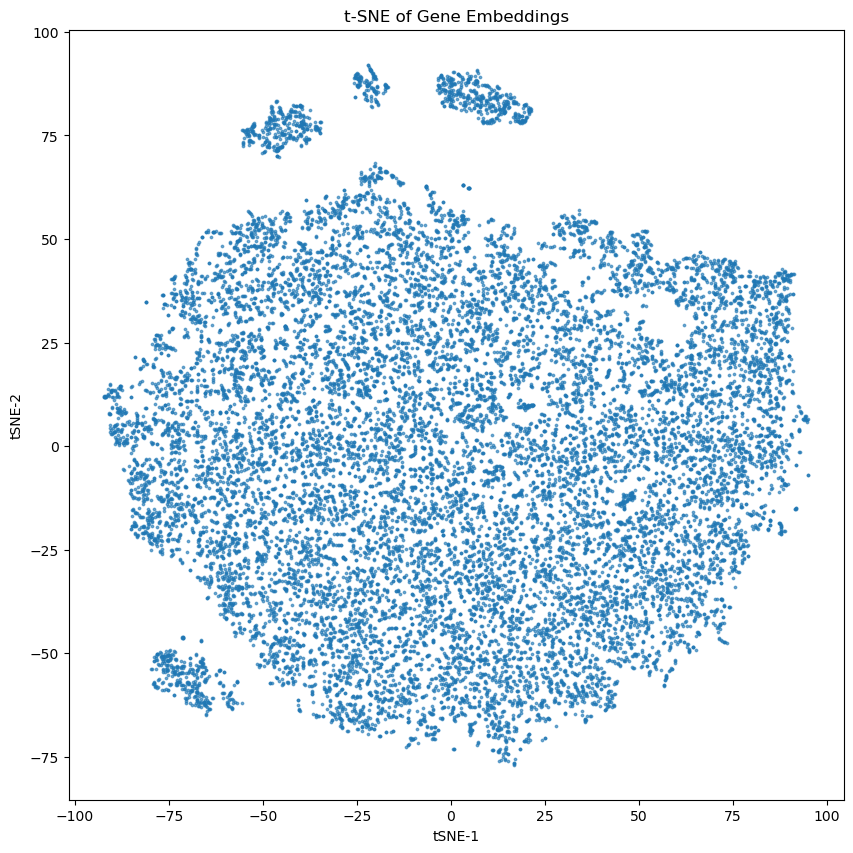

In [12]:
plt.figure(figsize=(10,10))
plt.scatter(tsne_emb[:,0], tsne_emb[:,1], s=3, alpha=0.6)
plt.title("t-SNE of Gene Embeddings")
plt.xlabel("tSNE-1")
plt.ylabel("tSNE-2")
plt.show()


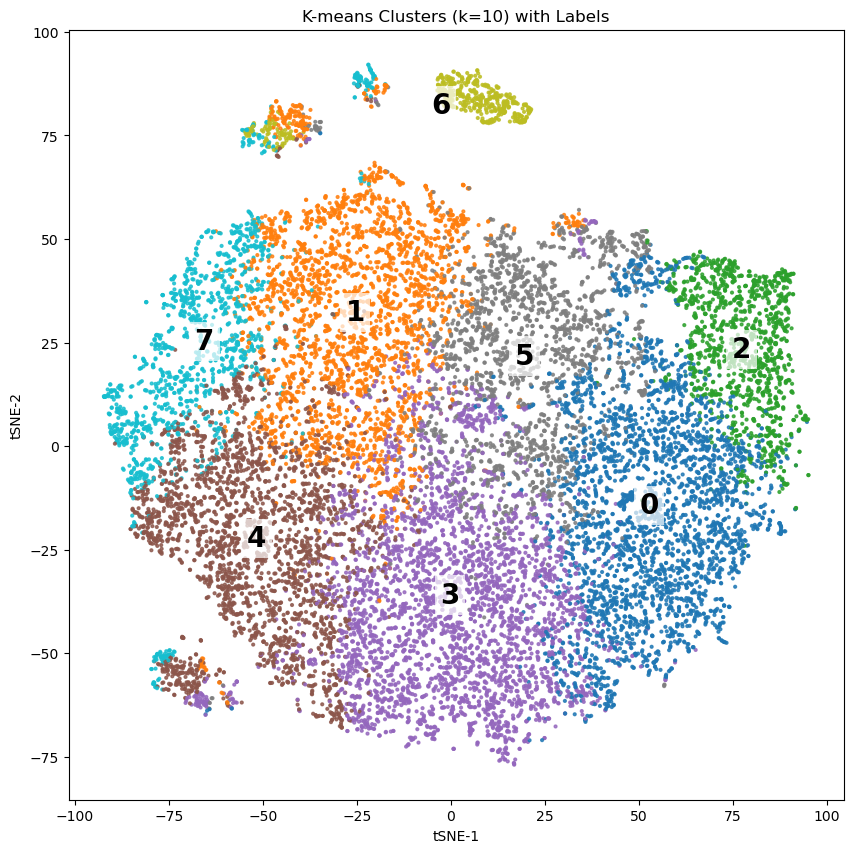

In [27]:
k = 8  # number of clusters
km = KMeans(n_clusters=k, random_state=42)
clusters = km.fit_predict(gene_embed)

clusters[:20]

plt.figure(figsize=(10,10))

# Scatter points
plt.scatter(
    tsne_emb[:,0], tsne_emb[:,1],
    c=clusters,
    cmap="tab10",
    s=4,
    alpha=0.8
)

# Add cluster labels at the cluster centroid
for c in range(k):
    cx = tsne_emb[clusters == c, 0].mean()
    cy = tsne_emb[clusters == c, 1].mean()
    plt.text(
        cx, cy, str(c),
        fontsize=20, fontweight="bold",
        color="black",
        ha="center", va="center",
        bbox=dict(facecolor="white", alpha=0.7, edgecolor='none')
    )

plt.title("K-means Clusters (k=10) with Labels")
plt.xlabel("tSNE-1")
plt.ylabel("tSNE-2")
plt.show()



/home/walt/miniconda3/envs/esm2/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/walt/miniconda3/envs/esm2/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


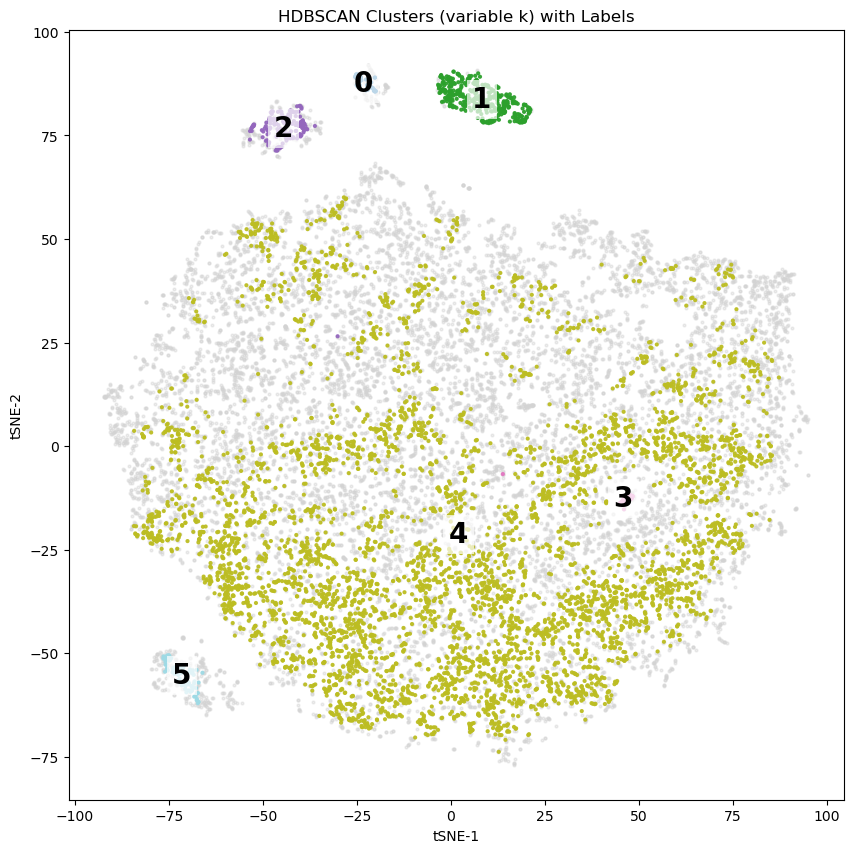

In [23]:
import hdbscan

# HDBSCAN clustering
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=30,
    min_samples=10,
    metric='euclidean',
    cluster_selection_method='leaf',   
)
clusters = clusterer.fit_predict(gene_embed)
clusters[:20]

import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10,10))

# Mask noise points (-1)
is_noise = clusters == -1
is_cluster = clusters != -1

# Plot noise in light gray
plt.scatter(
    tsne_emb[is_noise, 0],
    tsne_emb[is_noise, 1],
    c='lightgray',
    s=4,
    alpha=0.4,
    label='Noise'
)

# Plot clusters
plt.scatter(
    tsne_emb[is_cluster, 0],
    tsne_emb[is_cluster, 1],
    c=clusters[is_cluster],
    cmap='tab20',
    s=4,
    alpha=0.9
)

# Get number of clusters (excluding noise)
unique_clusters = [c for c in np.unique(clusters) if c != -1]

# Add cluster labels at centroid of each cluster
for c in unique_clusters:
    cx = tsne_emb[clusters == c, 0].mean()
    cy = tsne_emb[clusters == c, 1].mean()
    
    plt.text(
        cx, cy, str(c),
        fontsize=20, fontweight="bold",
        color="black",
        ha="center", va="center",
        bbox=dict(facecolor="white", alpha=0.7, edgecolor='none')
    )

plt.title("HDBSCAN Clusters (variable k) with Labels")
plt.xlabel("tSNE-1")
plt.ylabel("tSNE-2")
plt.show()



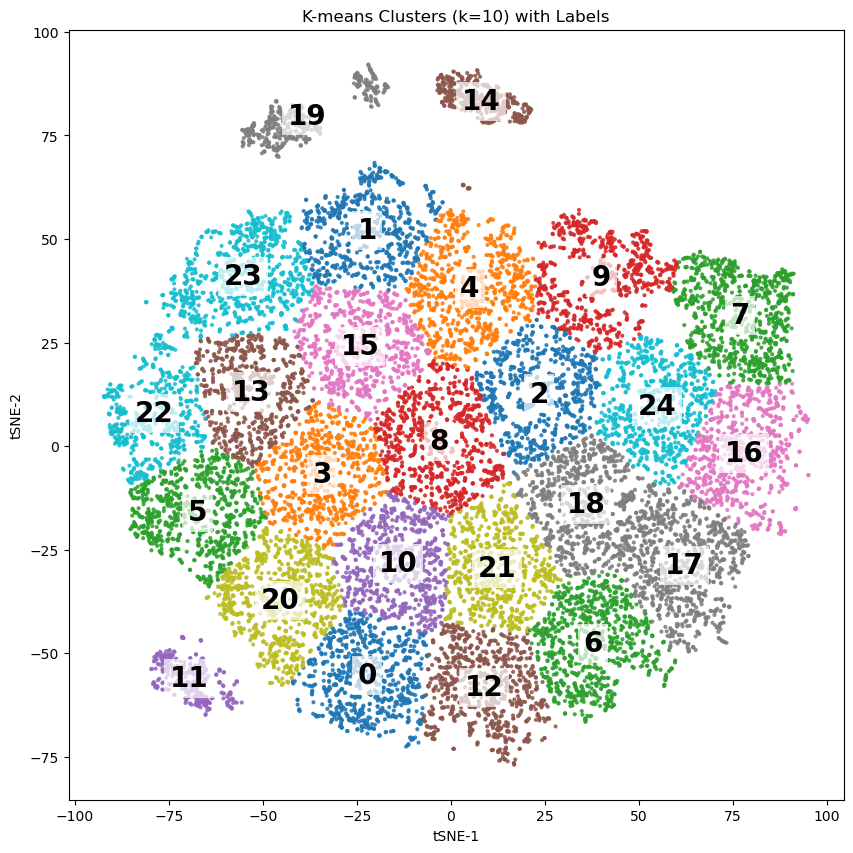

In [ ]:
from sklearn.cluster import KMeans
import numpy as np

k = 25  # number of clusters

km = KMeans(
    n_clusters=k,
    init='k-means++',
    random_state=42,
    max_iter=300,
    n_init=10,                    
)
clusters = km.fit_predict(tsne_emb)

plt.figure(figsize=(10,10))

# Scatter points
plt.scatter(
    tsne_emb[:,0], tsne_emb[:,1],
    c=clusters,
    cmap="tab10",
    s=4,
    alpha=0.8
)

# Add cluster labels at the cluster centroid
for c in range(k):
    cx = tsne_emb[clusters == c, 0].mean()
    cy = tsne_emb[clusters == c, 1].mean()
    plt.text(
        cx, cy, str(c),
        fontsize=20, fontweight="bold",
        color="black",
        ha="center", va="center",
        bbox=dict(facecolor="white", alpha=0.7, edgecolor='none')
    )

plt.title("K-means Clusters (k=10) with Labels")
plt.xlabel("tSNE-1")
plt.ylabel("tSNE-2")
plt.show()



In [40]:
# load the gene order file from training if you have one
gene_order = pd.read_csv("./data/archs4/processed_short_proteins/test_gene_order_short.csv")

print("Columns:", gene_order.columns.tolist())
print(gene_order.head(10))

gene_names = gene_order["gene_symbol"].tolist()

len(gene_names)


Columns: ['gene_symbol']
  gene_symbol
0      MT-ND1
1      MT-ND2
2      MT-CO1
3      MT-CO2
4     MT-ATP8
5     MT-ATP6
6      MT-CO3
7      MT-ND3
8     MT-ND4L
9      MT-ND4


19357

In [41]:
enrichment_results = {}

for c in range(k):
    gene_list = [gene_names[i] for i in range(len(gene_names)) if clusters[i] == c]

    enr = gp.enrichr(
        gene_list=gene_list,
        gene_sets=["GO_Biological_Process_2021"],
        organism="Human",
        cutoff=0.05
    )
    
    enrichment_results[c] = enr.results
    print(f"Cluster {c}: {len(enr.results)} significant GO terms")


Cluster 0: 2855 significant GO terms
Cluster 1: 2003 significant GO terms
Cluster 2: 3370 significant GO terms
Cluster 3: 2837 significant GO terms
Cluster 4: 3333 significant GO terms
Cluster 5: 2721 significant GO terms
Cluster 6: 2912 significant GO terms
Cluster 7: 3716 significant GO terms
Cluster 8: 3327 significant GO terms
Cluster 9: 2561 significant GO terms
Cluster 10: 2852 significant GO terms
Cluster 11: 202 significant GO terms
Cluster 12: 3065 significant GO terms
Cluster 13: 2490 significant GO terms
Cluster 14: 54 significant GO terms
Cluster 15: 2652 significant GO terms
Cluster 16: 3332 significant GO terms
Cluster 17: 3456 significant GO terms
Cluster 18: 3413 significant GO terms
Cluster 19: 1120 significant GO terms
Cluster 20: 2691 significant GO terms
Cluster 21: 3065 significant GO terms
Cluster 22: 1999 significant GO terms
Cluster 23: 2082 significant GO terms
Cluster 24: 2985 significant GO terms


In [42]:
kegg_results = {}

for c in range(k):
    gene_list = [gene_names[i] for i in range(len(gene_names)) if clusters[i] == c]

    enr = gp.enrichr(
        gene_list=gene_list,
        gene_sets=["KEGG_2021_Human"],
        organism="Human",
        cutoff=0.05
    )
    
    kegg_results[c] = enr.results
    print(f"Cluster {c}: {len(enr.results)} KEGG pathways")


Cluster 0: 223 KEGG pathways
Cluster 1: 227 KEGG pathways
Cluster 2: 246 KEGG pathways
Cluster 3: 280 KEGG pathways
Cluster 4: 283 KEGG pathways
Cluster 5: 251 KEGG pathways
Cluster 6: 283 KEGG pathways
Cluster 7: 297 KEGG pathways
Cluster 8: 266 KEGG pathways
Cluster 9: 260 KEGG pathways
Cluster 10: 283 KEGG pathways
Cluster 11: 16 KEGG pathways
Cluster 12: 252 KEGG pathways
Cluster 13: 210 KEGG pathways
Cluster 14: 2 KEGG pathways
Cluster 15: 273 KEGG pathways
Cluster 16: 271 KEGG pathways
Cluster 17: 294 KEGG pathways
Cluster 18: 294 KEGG pathways
Cluster 19: 81 KEGG pathways
Cluster 20: 233 KEGG pathways
Cluster 21: 293 KEGG pathways
Cluster 22: 208 KEGG pathways
Cluster 23: 231 KEGG pathways
Cluster 24: 262 KEGG pathways


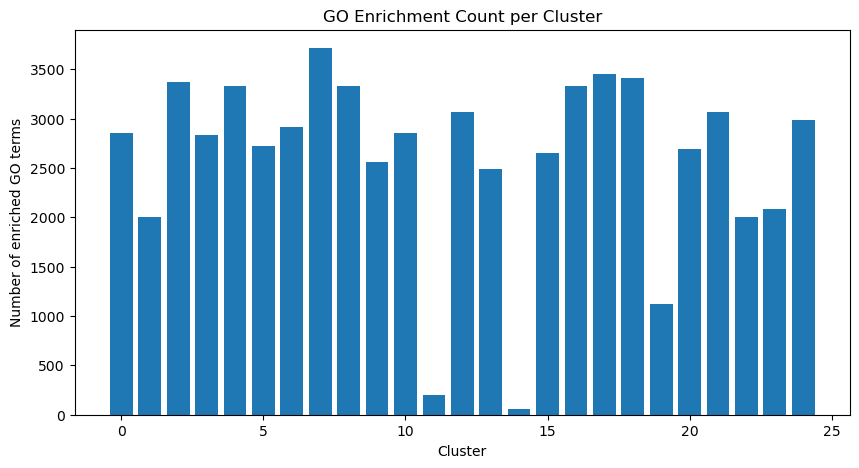

In [43]:
go_counts = [len(enrichment_results[c]) for c in range(k)]

plt.figure(figsize=(10,5))
plt.bar(range(k), go_counts)
plt.xlabel("Cluster")
plt.ylabel("Number of enriched GO terms")
plt.title("GO Enrichment Count per Cluster")
plt.show()


In [44]:
def compute_rich_factor(df):
    rf = []
    for s in df["Overlap"]:
        a, b = s.split("/")
        rf.append(int(a) / int(b))
    return np.array(rf)


In [45]:
cell_cycle_terms = [
    "cell cycle",
    "mitotic",
    "chromosome",
    "DNA replication",
    "splicing",
    "RNA splicing",
    "DNA repair",
    "cell division",
    "chromatin organization"
]


immune_terms = [
    "immune",
    "defense",
    "antigen",
    "interferon",
    "T cell",
    "B cell",
    "inflammatory",
    "cytokine",
    "pathogen",
    "response to bacterium",
]

import re

def count_matches(df, keywords):
    if df is None or len(df) == 0:
        return 0
    pattern = "|".join([re.escape(k) for k in keywords])
    return df["Term"].str.contains(pattern, case=False, regex=True).sum()

cluster_theme_scores = {}

for c in range(k):
    df = enrichment_results[c]
    
    score_cellcycle = count_matches(df, cell_cycle_terms)
    score_immune    = count_matches(df, immune_terms)
    
    cluster_theme_scores[c] = {
        "cell_cycle_score": score_cellcycle,
        "immune_score": score_immune,
        "n_terms": len(df)
    }

cluster_theme_scores



{0: {'cell_cycle_score': np.int64(117),
  'immune_score': np.int64(138),
  'n_terms': 2855},
 1: {'cell_cycle_score': np.int64(54),
  'immune_score': np.int64(117),
  'n_terms': 2003},
 2: {'cell_cycle_score': np.int64(72),
  'immune_score': np.int64(254),
  'n_terms': 3370},
 3: {'cell_cycle_score': np.int64(79),
  'immune_score': np.int64(196),
  'n_terms': 2837},
 4: {'cell_cycle_score': np.int64(85),
  'immune_score': np.int64(235),
  'n_terms': 3333},
 5: {'cell_cycle_score': np.int64(116),
  'immune_score': np.int64(125),
  'n_terms': 2721},
 6: {'cell_cycle_score': np.int64(120),
  'immune_score': np.int64(150),
  'n_terms': 2912},
 7: {'cell_cycle_score': np.int64(116),
  'immune_score': np.int64(204),
  'n_terms': 3716},
 8: {'cell_cycle_score': np.int64(74),
  'immune_score': np.int64(191),
  'n_terms': 3327},
 9: {'cell_cycle_score': np.int64(78),
  'immune_score': np.int64(190),
  'n_terms': 2561},
 10: {'cell_cycle_score': np.int64(91),
  'immune_score': np.int64(172),
  '

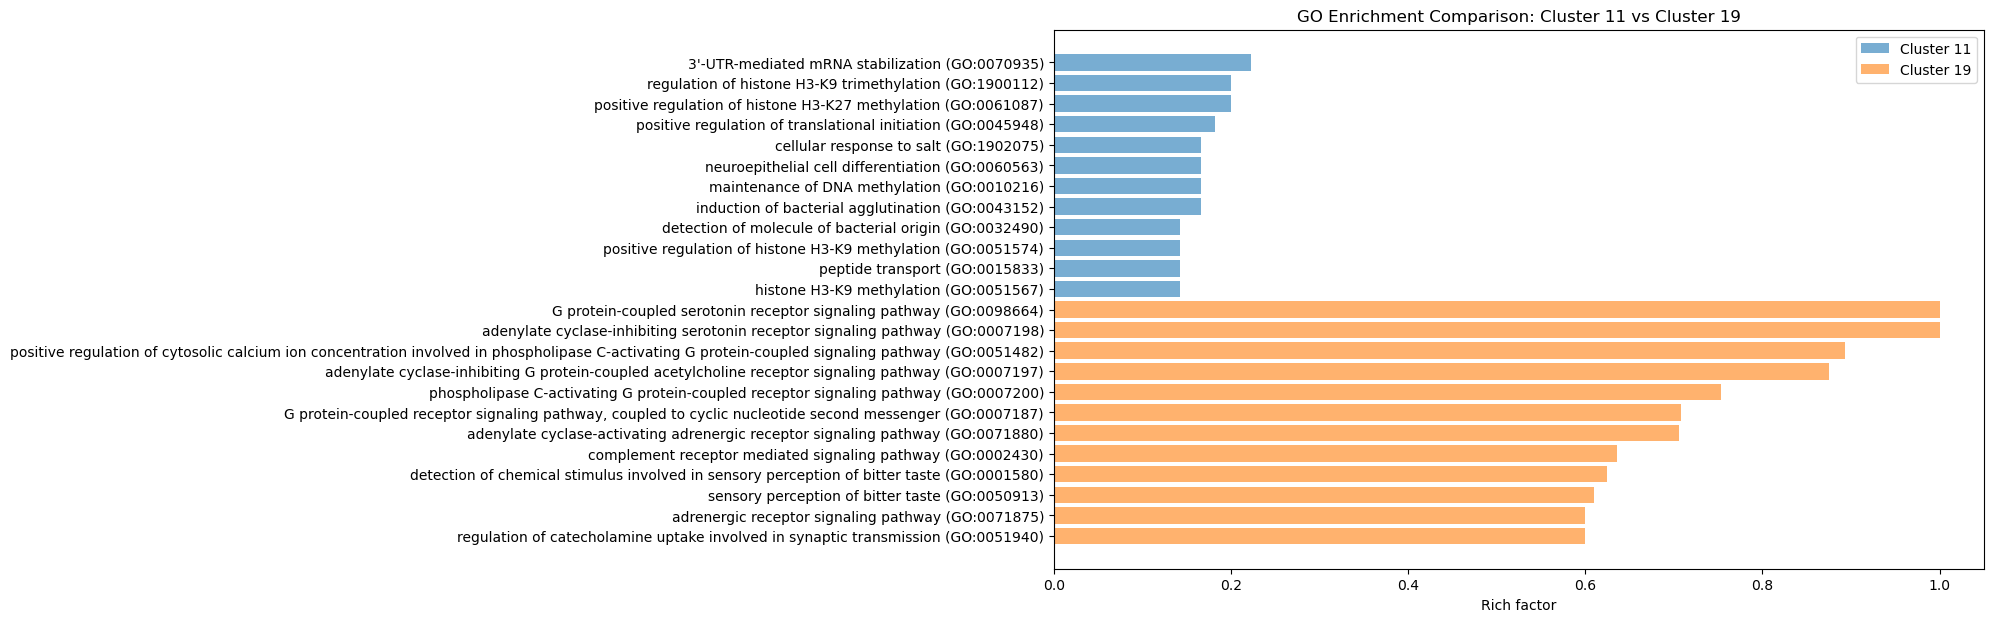


Top 5 GO terms for Cluster 11:
1. 3'-UTR-mediated mRNA stabilization (GO:0070935) (rich factor = 0.222)
2. regulation of histone H3-K9 trimethylation (GO:1900112) (rich factor = 0.200)
3. positive regulation of histone H3-K27 methylation (GO:0061087) (rich factor = 0.200)
4. positive regulation of translational initiation (GO:0045948) (rich factor = 0.182)
5. cellular response to salt (GO:1902075) (rich factor = 0.167)

Top 5 GO terms for Cluster 19:
1. G protein-coupled serotonin receptor signaling pathway (GO:0098664) (rich factor = 1.000)
2. adenylate cyclase-inhibiting serotonin receptor signaling pathway (GO:0007198) (rich factor = 1.000)
3. positive regulation of cytosolic calcium ion concentration involved in phospholipase C-activating G protein-coupled signaling pathway (GO:0051482) (rich factor = 0.893)
4. adenylate cyclase-inhibiting G protein-coupled acetylcholine receptor signaling pathway (GO:0007197) (rich factor = 0.875)
5. phospholipase C-activating G protein-coupled r

In [67]:
c1, c2 = 11, 19

df1 = enrichment_results[c1].copy()
df2 = enrichment_results[c2].copy()

df1["rich_factor"] = compute_rich_factor(df1)
df2["rich_factor"] = compute_rich_factor(df2)

# Top 12 for clean plot
df1_top = df1.nlargest(12, "rich_factor")
df2_top = df2.nlargest(12, "rich_factor")

plt.figure(figsize=(12,7))
plt.barh(df1_top["Term"], df1_top["rich_factor"], alpha=0.6, label=f"Cluster {c1}")
plt.barh(df2_top["Term"], df2_top["rich_factor"], alpha=0.6, label=f"Cluster {c2}")
plt.xlabel("Rich factor")
plt.title(f"GO Enrichment Comparison: Cluster {c1} vs Cluster {c2}")
plt.legend()
plt.gca().invert_yaxis()
plt.show()


print(f"\nTop 5 GO terms for Cluster {c1}:")
for i, (term, rf) in enumerate(zip(df1_top["Term"].head(5),
                                   df1_top["rich_factor"].head(5)), 1):
    print(f"{i}. {term} (rich factor = {rf:.3f})")

print(f"\nTop 5 GO terms for Cluster {c2}:")
for i, (term, rf) in enumerate(zip(df2_top["Term"].head(5),
                                   df2_top["rich_factor"].head(5)), 1):
    print(f"{i}. {term} (rich factor = {rf:.3f})")


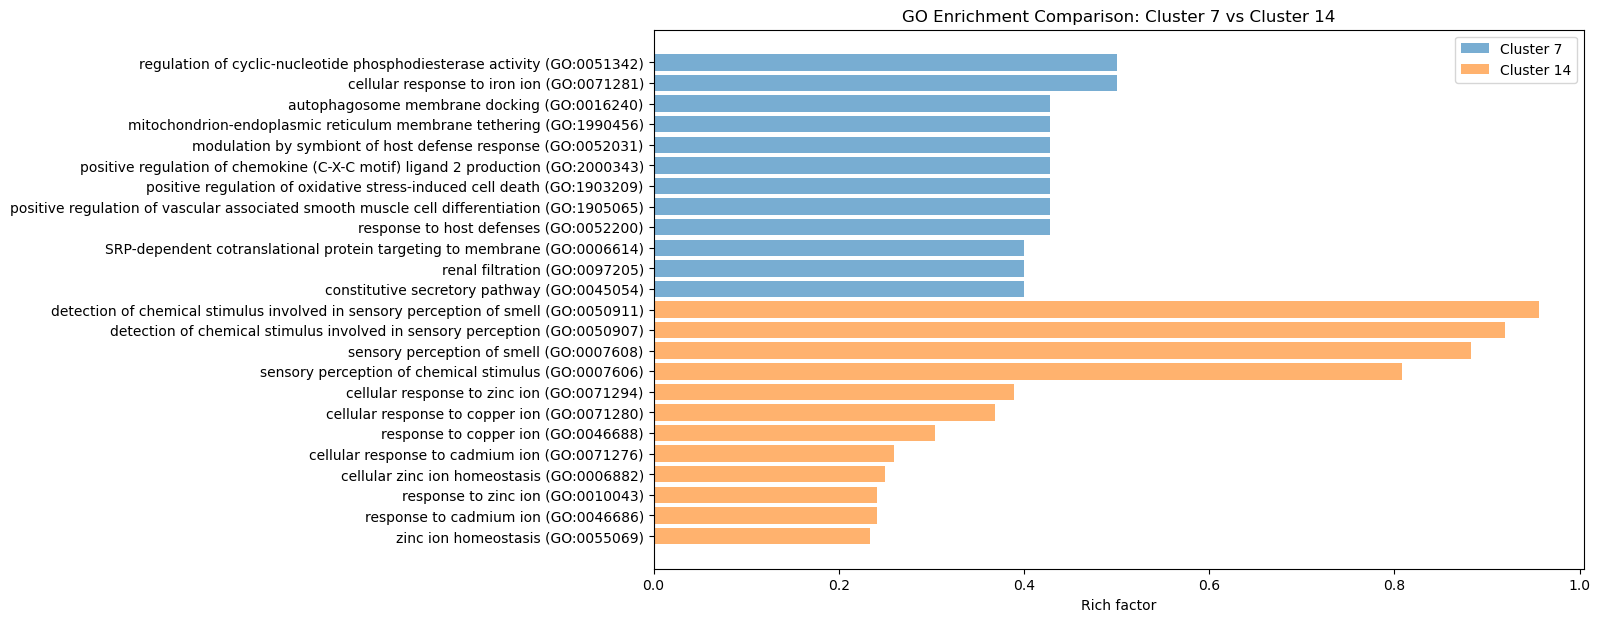


Top 5 GO terms for Cluster 7:
1. regulation of cyclic-nucleotide phosphodiesterase activity (GO:0051342) (rich factor = 0.500)
2. cellular response to iron ion (GO:0071281) (rich factor = 0.500)
3. autophagosome membrane docking (GO:0016240) (rich factor = 0.429)
4. mitochondrion-endoplasmic reticulum membrane tethering (GO:1990456) (rich factor = 0.429)
5. modulation by symbiont of host defense response (GO:0052031) (rich factor = 0.429)

Top 5 GO terms for Cluster 14:
1. detection of chemical stimulus involved in sensory perception of smell (GO:0050911) (rich factor = 0.957)
2. detection of chemical stimulus involved in sensory perception (GO:0050907) (rich factor = 0.920)
3. sensory perception of smell (GO:0007608) (rich factor = 0.883)
4. sensory perception of chemical stimulus (GO:0007606) (rich factor = 0.808)
5. cellular response to zinc ion (GO:0071294) (rich factor = 0.389)


In [68]:
c1, c2 = 7, 14

df1 = enrichment_results[c1].copy()
df2 = enrichment_results[c2].copy()

df1["rich_factor"] = compute_rich_factor(df1)
df2["rich_factor"] = compute_rich_factor(df2)

# Top 12 for clean plot
df1_top = df1.nlargest(12, "rich_factor")
df2_top = df2.nlargest(12, "rich_factor")

plt.figure(figsize=(12,7))
plt.barh(df1_top["Term"], df1_top["rich_factor"], alpha=0.6, label=f"Cluster {c1}")
plt.barh(df2_top["Term"], df2_top["rich_factor"], alpha=0.6, label=f"Cluster {c2}")
plt.xlabel("Rich factor")
plt.title(f"GO Enrichment Comparison: Cluster {c1} vs Cluster {c2}")
plt.legend()
plt.gca().invert_yaxis()
plt.show()

print(f"\nTop 5 GO terms for Cluster {c1}:")
for i, (term, rf) in enumerate(zip(df1_top["Term"].head(5),
                                   df1_top["rich_factor"].head(5)), 1):
    print(f"{i}. {term} (rich factor = {rf:.3f})")

print(f"\nTop 5 GO terms for Cluster {c2}:")
for i, (term, rf) in enumerate(zip(df2_top["Term"].head(5),
                                   df2_top["rich_factor"].head(5)), 1):
    print(f"{i}. {term} (rich factor = {rf:.3f})")



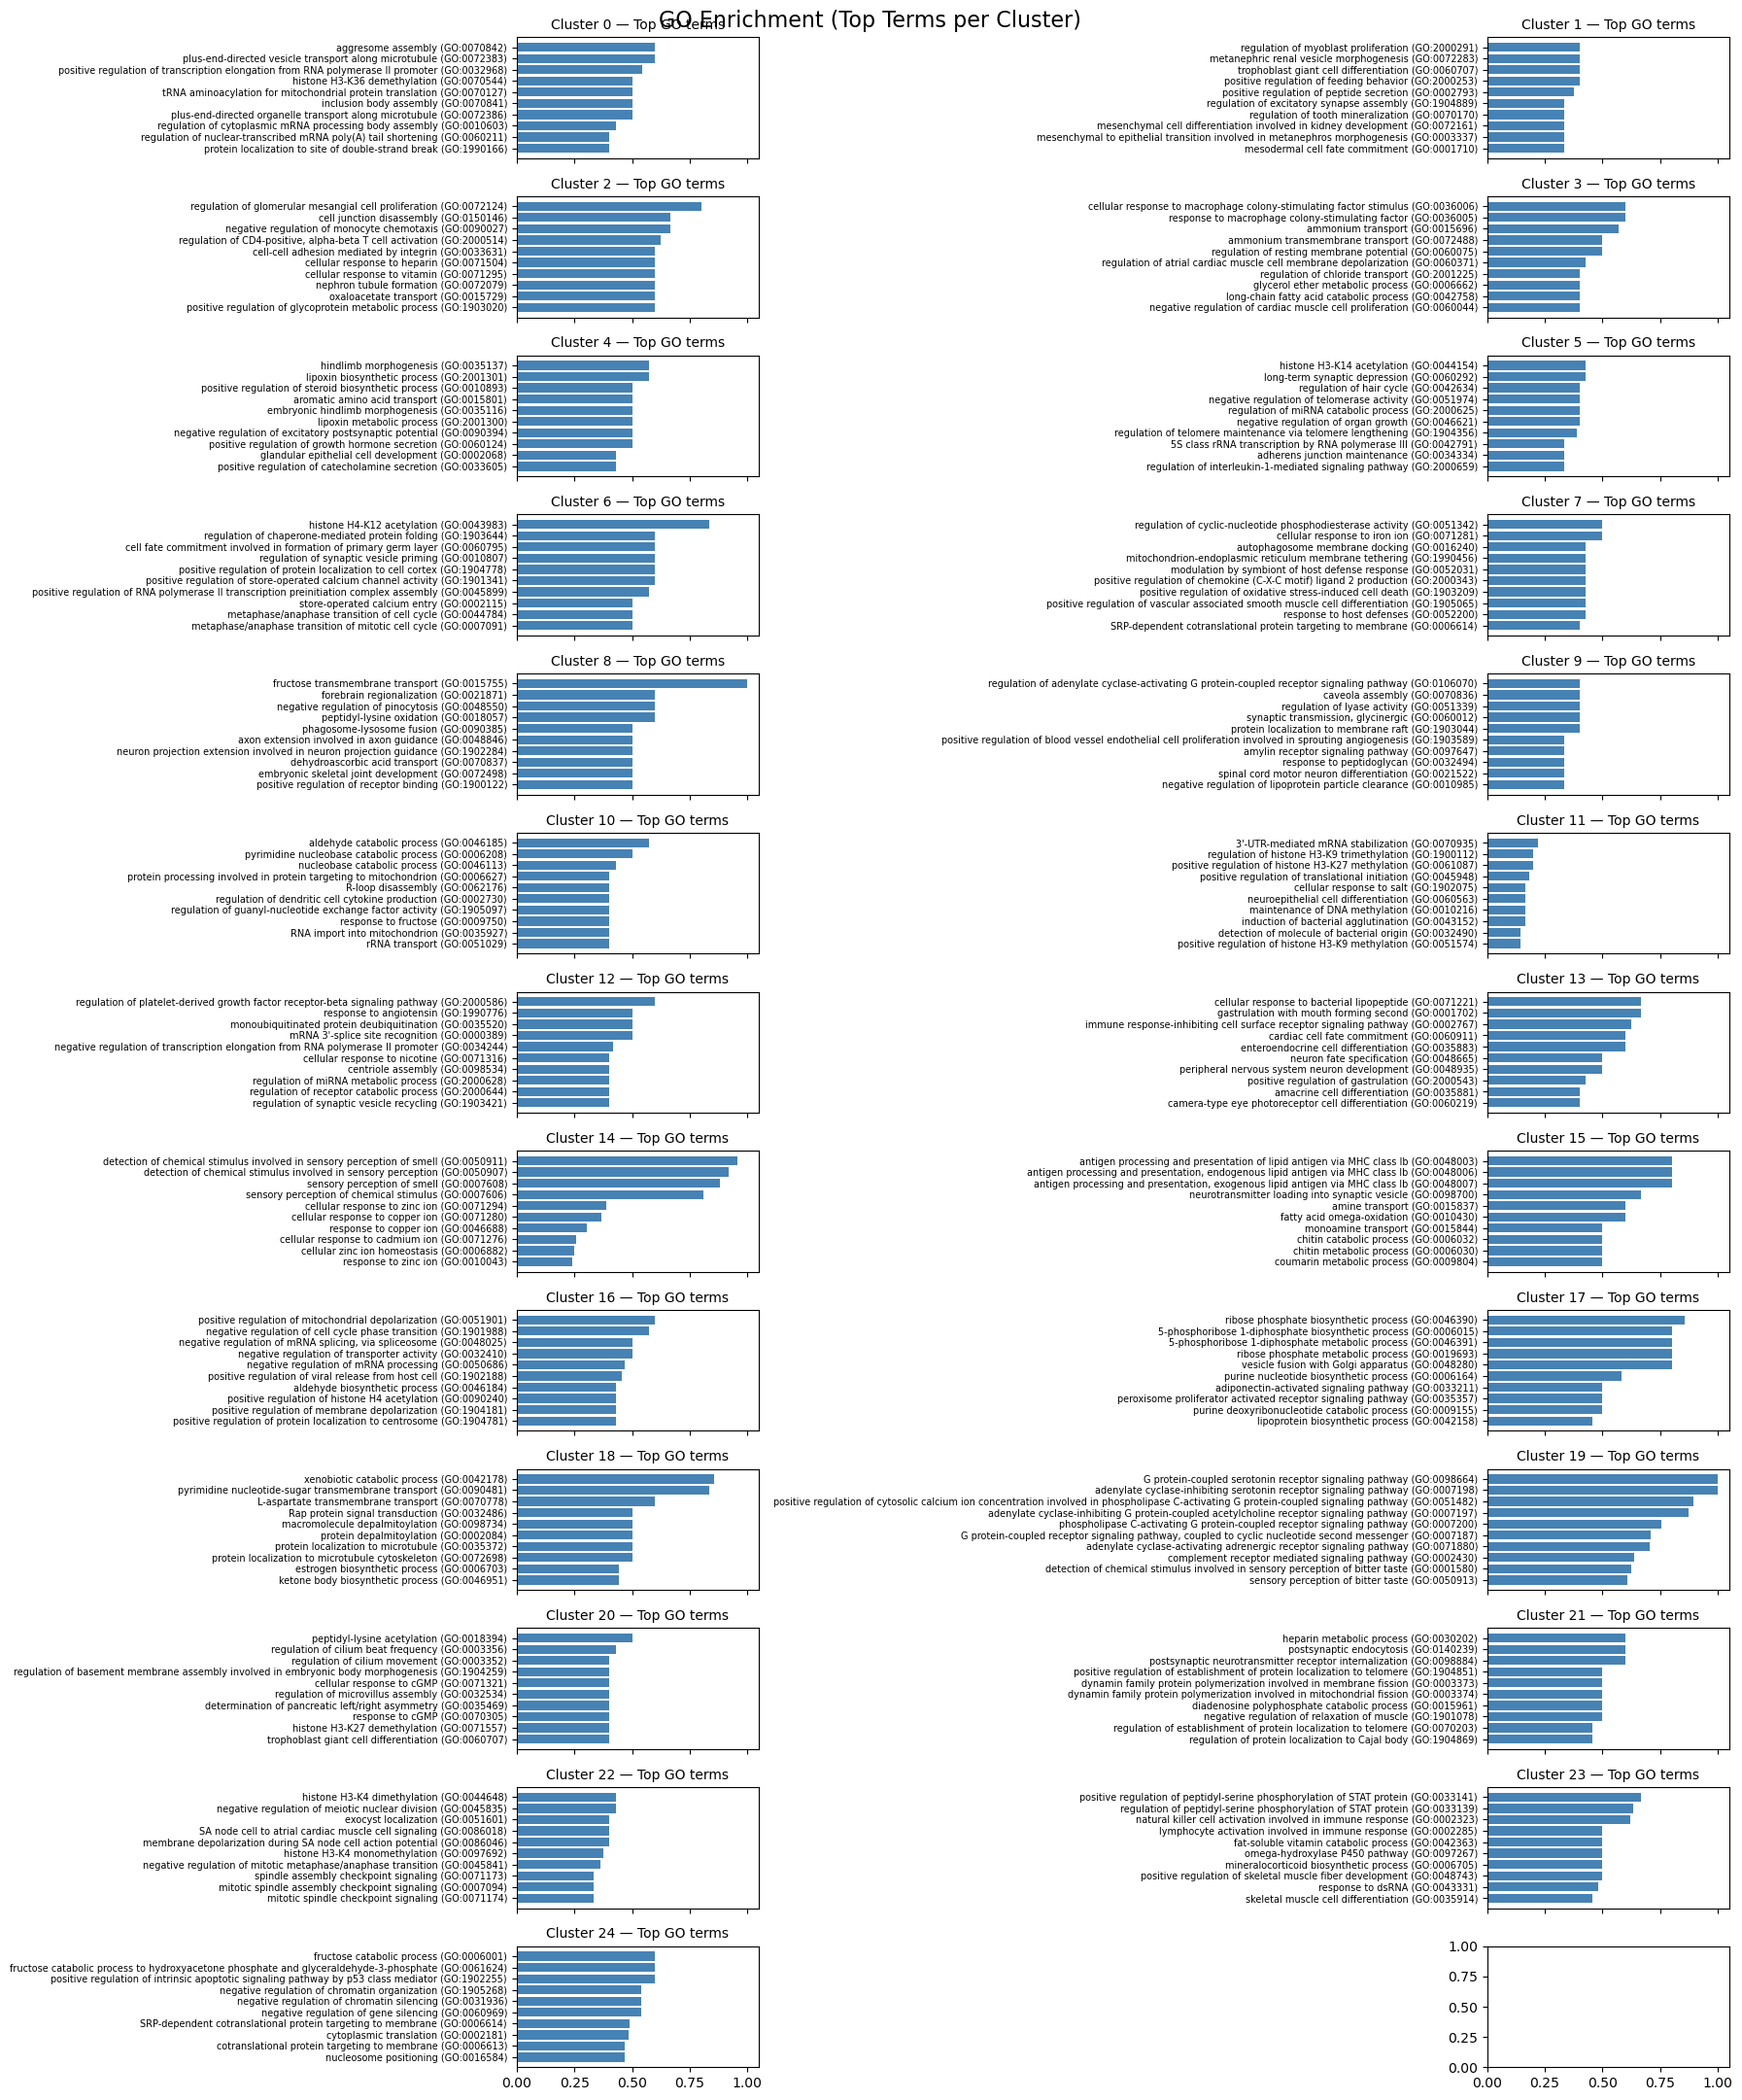

In [54]:
import matplotlib.pyplot as plt

# Prepare cluster → df mapping
cluster_top = {}

for c in range(k):
    df = enrichment_results[c].copy()
    df["rich_factor"] = compute_rich_factor(df)

    # keep top N
    df_top = df.nlargest(10, "rich_factor")
    cluster_top[c] = df_top

# Plot
rows = (k + 2) // 2
cols = 2
fig, axes = plt.subplots(rows, cols, figsize=(18, 22), sharex=True)

for idx, c in enumerate(range(k)):
    ax = axes[idx // cols][idx % cols]
    df = cluster_top[c]

    ax.barh(df["Term"], df["rich_factor"], color="steelblue")
    ax.set_title(f"Cluster {c} — Top GO terms", fontsize=10)
    ax.invert_yaxis()
    ax.tick_params(axis='y', labelsize=7)

fig.suptitle("GO Enrichment (Top Terms per Cluster)", fontsize=16)
plt.tight_layout()
plt.show()


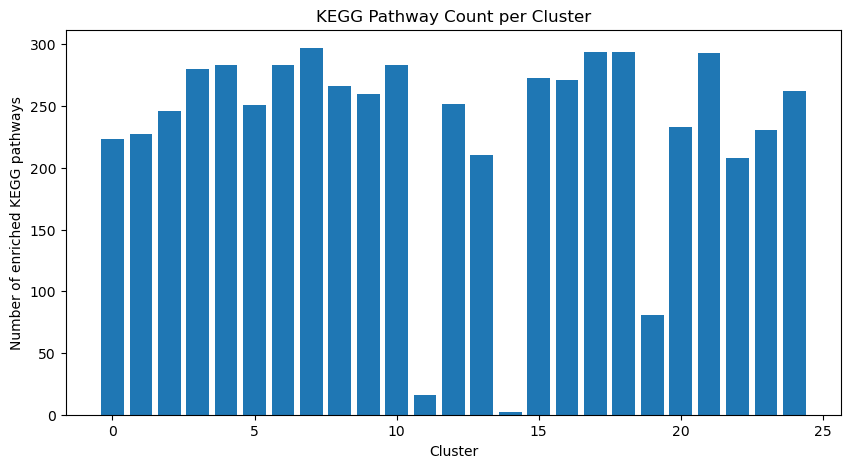

In [55]:
kegg_counts = [len(kegg_results[c]) for c in range(k)]

plt.figure(figsize=(10,5))
plt.bar(range(k), kegg_counts)
plt.xlabel("Cluster")
plt.ylabel("Number of enriched KEGG pathways")
plt.title("KEGG Pathway Count per Cluster")
plt.show()


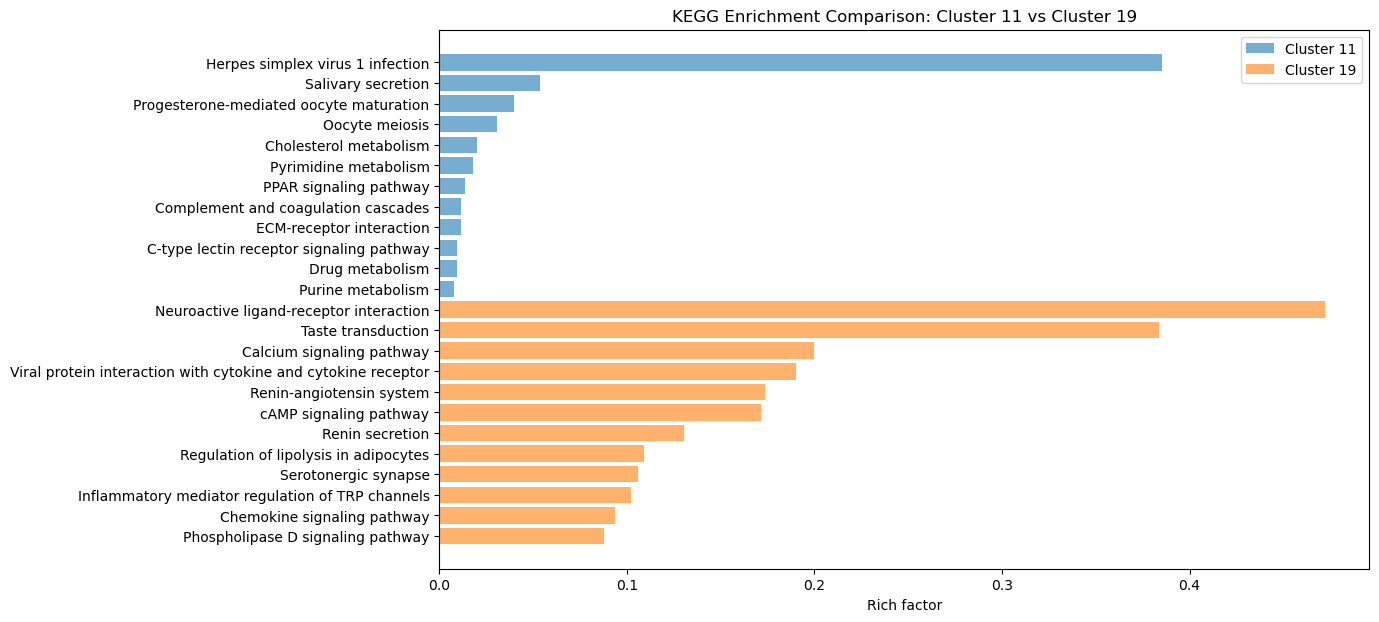


Top 5 KEGG terms for Cluster 11:
1. Herpes simplex virus 1 infection (rich factor = 0.386)
2. Salivary secretion (rich factor = 0.054)
3. Progesterone-mediated oocyte maturation (rich factor = 0.040)
4. Oocyte meiosis (rich factor = 0.031)
5. Cholesterol metabolism (rich factor = 0.020)

Top 5 KEGG terms for Cluster 19:
1. Neuroactive ligand-receptor interaction (rich factor = 0.472)
2. Taste transduction (rich factor = 0.384)
3. Calcium signaling pathway (rich factor = 0.200)
4. Viral protein interaction with cytokine and cytokine receptor (rich factor = 0.190)
5. Renin-angiotensin system (rich factor = 0.174)


In [65]:
def compute_kegg_rich_factor(df):
    rf = []
    for s in df["Overlap"]:
        a, b = s.split("/")
        rf.append(int(a) / int(b))
    return np.array(rf)


c1, c2 = 11, 19

df1 = kegg_results[c1].copy()
df2 = kegg_results[c2].copy()

df1["rich_factor"] = compute_kegg_rich_factor(df1)
df2["rich_factor"] = compute_kegg_rich_factor(df2)

df1_top = df1.nlargest(12, "rich_factor")
df2_top = df2.nlargest(12, "rich_factor")

plt.figure(figsize=(12,7))
plt.barh(df1_top["Term"], df1_top["rich_factor"], alpha=0.6, label=f"Cluster {c1}")
plt.barh(df2_top["Term"], df2_top["rich_factor"], alpha=0.6, label=f"Cluster {c2}")
plt.xlabel("Rich factor")
plt.title(f"KEGG Enrichment Comparison: Cluster {c1} vs Cluster {c2}")
plt.legend()
plt.gca().invert_yaxis()
plt.show()

print(f"\nTop 5 KEGG terms for Cluster {c1}:")
for i, (term, rf) in enumerate(zip(df1_top["Term"].head(5),
                                   df1_top["rich_factor"].head(5)), 1):
    print(f"{i}. {term} (rich factor = {rf:.3f})")

print(f"\nTop 5 KEGG terms for Cluster {c2}:")
for i, (term, rf) in enumerate(zip(df2_top["Term"].head(5),
                                   df2_top["rich_factor"].head(5)), 1):
    print(f"{i}. {term} (rich factor = {rf:.3f})")


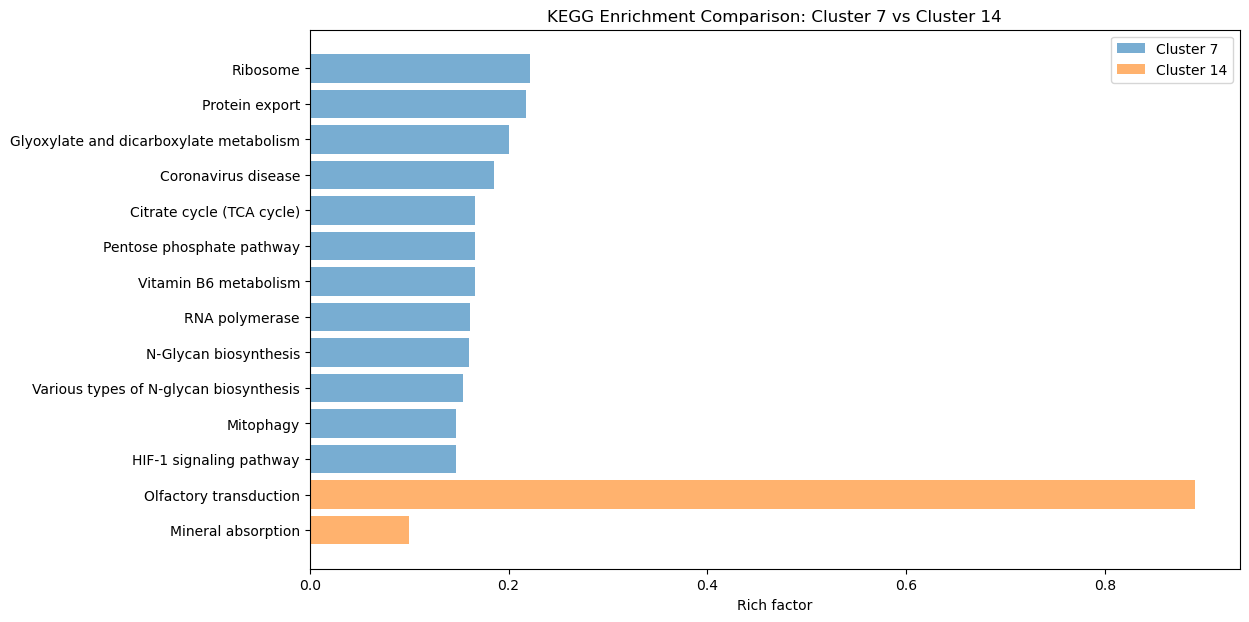


Top 5 KEGG terms for Cluster 7:
1. Ribosome (rich factor = 0.222)
2. Protein export (rich factor = 0.217)
3. Glyoxylate and dicarboxylate metabolism (rich factor = 0.200)
4. Coronavirus disease (rich factor = 0.185)
5. Citrate cycle (TCA cycle) (rich factor = 0.167)

Top 5 KEGG terms for Cluster 14:
1. Olfactory transduction (rich factor = 0.891)
2. Mineral absorption (rich factor = 0.100)


In [66]:
def compute_kegg_rich_factor(df):
    rf = []
    for s in df["Overlap"]:
        a, b = s.split("/")
        rf.append(int(a) / int(b))
    return np.array(rf)


c1, c2 = 7, 14

df1 = kegg_results[c1].copy()
df2 = kegg_results[c2].copy()

df1["rich_factor"] = compute_kegg_rich_factor(df1)
df2["rich_factor"] = compute_kegg_rich_factor(df2)

df1_top = df1.nlargest(12, "rich_factor")
df2_top = df2.nlargest(12, "rich_factor")

plt.figure(figsize=(12,7))
plt.barh(df1_top["Term"], df1_top["rich_factor"], alpha=0.6, label=f"Cluster {c1}")
plt.barh(df2_top["Term"], df2_top["rich_factor"], alpha=0.6, label=f"Cluster {c2}")
plt.xlabel("Rich factor")
plt.title(f"KEGG Enrichment Comparison: Cluster {c1} vs Cluster {c2}")
plt.legend()
plt.gca().invert_yaxis()
plt.show()

print(f"\nTop 5 KEGG terms for Cluster {c1}:")
for i, (term, rf) in enumerate(zip(df1_top["Term"].head(5),
                                   df1_top["rich_factor"].head(5)), 1):
    print(f"{i}. {term} (rich factor = {rf:.3f})")

print(f"\nTop 5 KEGG terms for Cluster {c2}:")
for i, (term, rf) in enumerate(zip(df2_top["Term"].head(5),
                                   df2_top["rich_factor"].head(5)), 1):
    print(f"{i}. {term} (rich factor = {rf:.3f})")


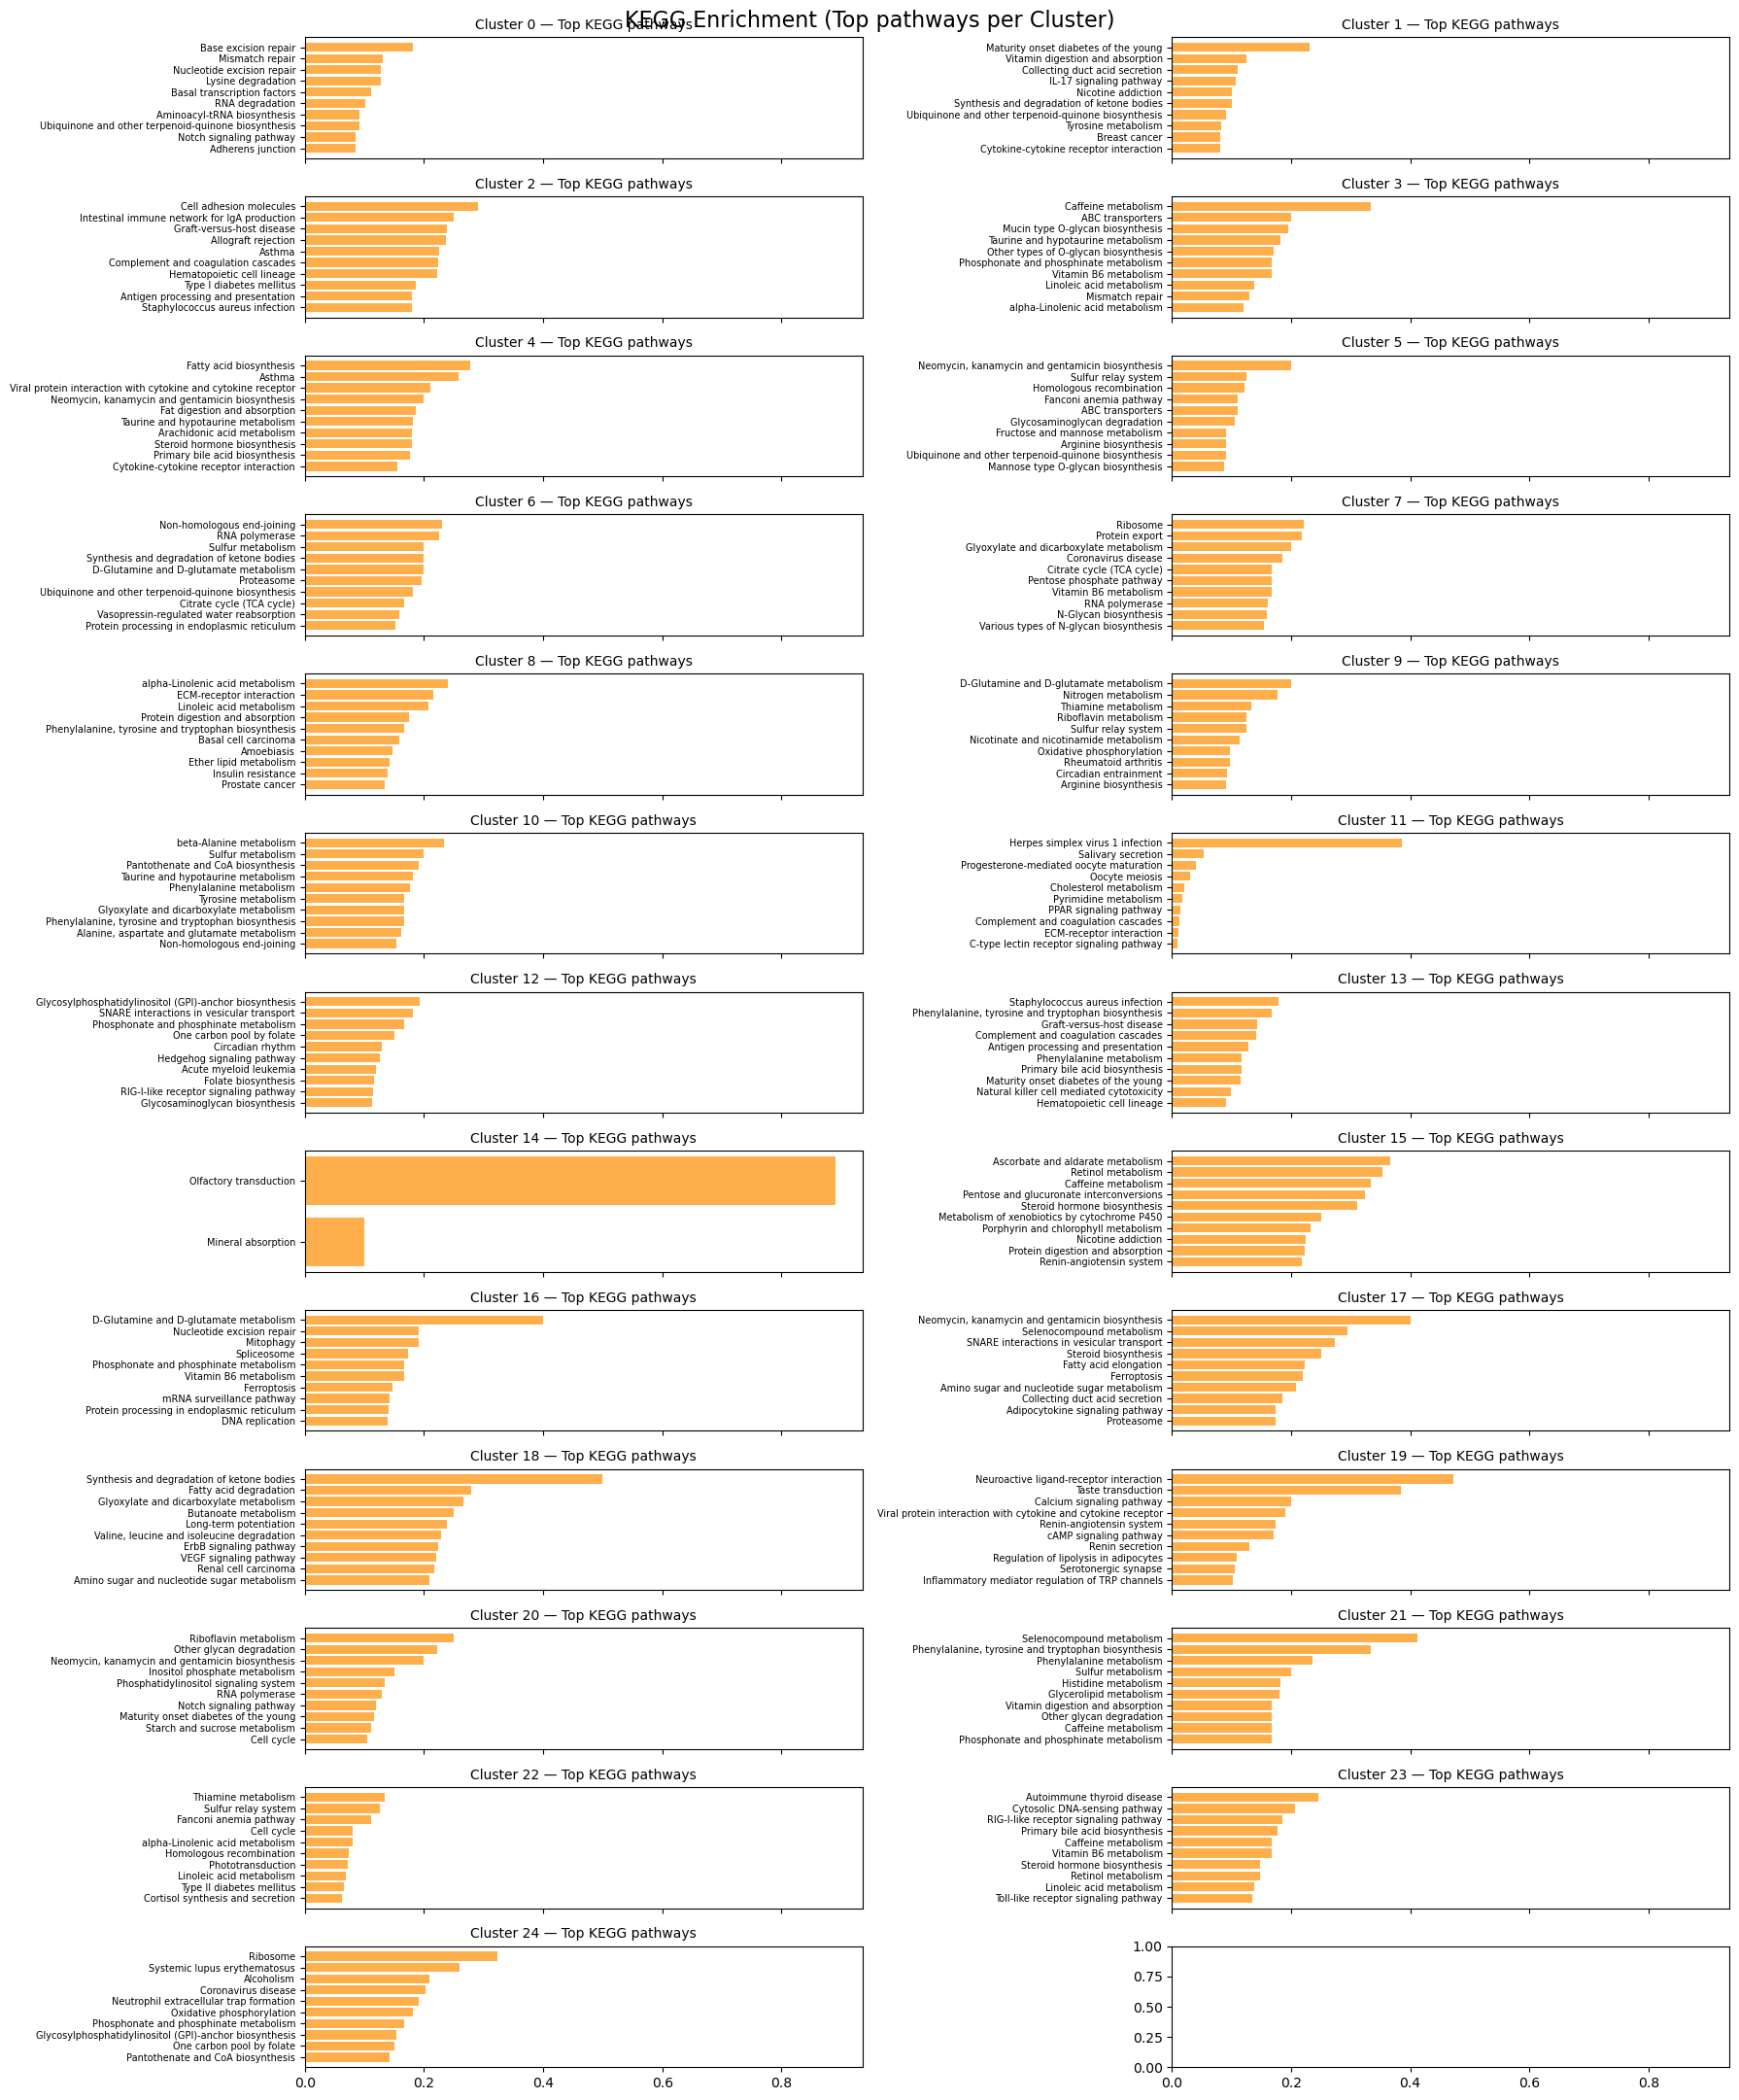

In [57]:
import matplotlib.pyplot as plt

# Compute top KEGG pathways per cluster
cluster_top_kegg = {}

for c in range(k):
    df = kegg_results[c].copy()
    df["rich_factor"] = compute_rich_factor(df)

    # keep top 10 KEGG terms
    df_top = df.nlargest(10, "rich_factor")
    cluster_top_kegg[c] = df_top

# Plot: 5 rows × 2 columns = 10 clusters
rows, cols = (k + 2) // 2, 2
fig, axes = plt.subplots(rows, cols, figsize=(18, 22), sharex=True)

for idx, c in enumerate(range(k)):
    ax = axes[idx // cols][idx % cols]
    df = cluster_top_kegg[c]

    ax.barh(df["Term"], df["rich_factor"], color="darkorange", alpha=0.7)
    ax.set_title(f"Cluster {c} — Top KEGG pathways", fontsize=10)
    ax.invert_yaxis()  # largest factor at top
    ax.tick_params(axis='y', labelsize=7)

fig.suptitle("KEGG Enrichment (Top pathways per Cluster)", fontsize=16)
plt.tight_layout()
plt.show()


In [58]:
# Canonical squamous epithelial program markers
squamous_markers = [
    "KRT5","KRT6A","KRT6B","KRT6C","KRT14","KRT16","KRT17","KRT19",
    "DSC1","DSC2","DSG1","DSG2","DSG3",
    "JUP","PKP1","PKP3",
    "IVL","SPRR1A","SPRR1B","SPRR2A","SPRR2B",
    "LCE1A","LCE1B","LCE1C","LCE2A","LCE2B",
    "TP63","SOX2","GRHL3","ELF3"
]

# Keep only genes that exist in your expression dataset
squamous_present = [g for g in squamous_markers if g in gene_names]
print("Squamous markers present:", squamous_present)

squamous_gene_mask = np.array([1 if g in squamous_present else 0 for g in gene_names])


Squamous markers present: ['KRT5', 'KRT6A', 'KRT6B', 'KRT6C', 'KRT14', 'KRT16', 'KRT17', 'KRT19', 'DSC1', 'DSC2', 'DSG1', 'DSG2', 'DSG3', 'JUP', 'PKP1', 'PKP3', 'IVL', 'SPRR1A', 'SPRR1B', 'SPRR2A', 'SPRR2B', 'LCE1A', 'LCE1B', 'LCE1C', 'LCE2A', 'LCE2B', 'TP63', 'SOX2', 'GRHL3', 'ELF3']


/tmp/ipykernel_46815/226083126.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_sq, x="cluster", y="squamous_markers", palette="viridis")


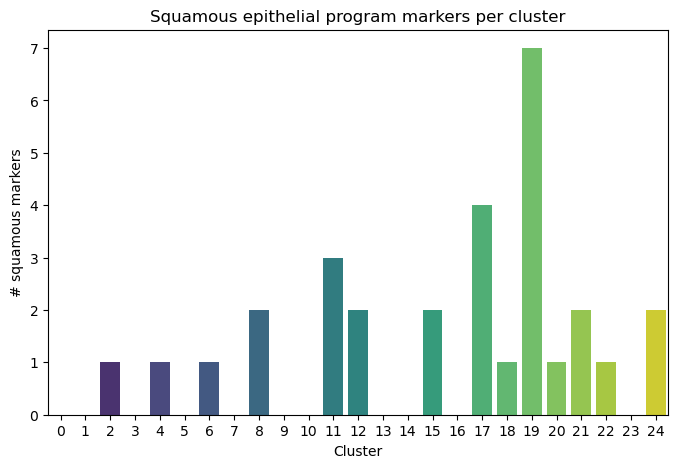

In [60]:
import pandas as pd
import seaborn as sns

cluster_squamous_counts = []

for c in range(k):
    cluster_indices = np.where(clusters == c)[0]
    genes_in_cluster = [gene_names[i] for i in cluster_indices]
    count = sum(1 for g in squamous_present if g in genes_in_cluster)
    cluster_squamous_counts.append(count)

df_sq = pd.DataFrame({
    "cluster": list(range(k)),
    "squamous_markers": cluster_squamous_counts
})

plt.figure(figsize=(8,5))
sns.barplot(data=df_sq, x="cluster", y="squamous_markers", palette="viridis")
plt.title("Squamous epithelial program markers per cluster")
plt.xlabel("Cluster")
plt.ylabel("# squamous markers")
plt.show()
